0.8101718572799441
0.8029311698508244
[[4886 1136]
 [1040 4401]]
0.8955780803963851


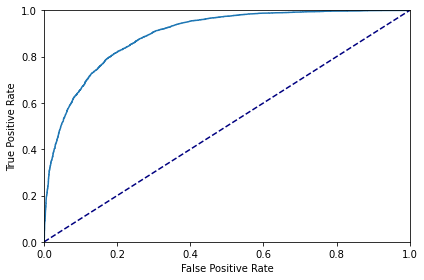

RF train accuracy: 0.820
RF test accuracy: 0.810
0.9057627431284757


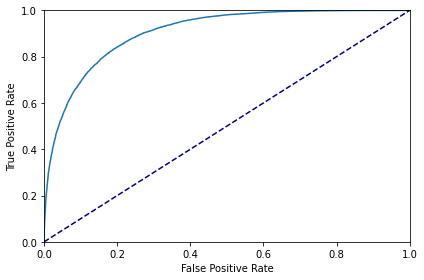

In [2]:
'''Runs and saves model'''
## Import necessary functions
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import csv
import itertools
import math
import pickle
# from tkinter import filedialog #Only use if using file selecter

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
# min_samples_leaf = 20 #default = 20
# max_depth = 4 #optimizes for experiment dataset; default = None
# max_leaf_nodes = 31 #default = 31
max_depth = 9 #default None
max_leaf = 20 #default 31
min_samples = 35 # default 20
test_size = 0.25
rand_state = 42

def name(df):
    '''df: dataframe 
    Make filename for model'''
    fl = ('_').join(sorted([i for i in df]))
    return fl
    
    
## Import Data

### Select file from computer to run
file_path = '../inc_csvs/adult_reconstruction.csv'
df =  pd.read_csv(file_path)
df= df[['Hours per Week', 'Age', 'Workclass', 'Highest Degree',
       'Marital Status', 'Race', 'Gender', 'Native Country', 'Occupation', 'Income']]
## Drop the income column

numFeatures = list(df.select_dtypes(include = 'number').drop(labels=['Income'], axis=1))

y = df[['Income']].copy().values.squeeze() # (49531,)
catFeatures = list(df.select_dtypes(include = object))

x = df[catFeatures + numFeatures].copy() # (49531, 13)
x[catFeatures] = x[catFeatures].astype("category")


## Fit training set to model

## Process categorical features for OneHotEncoder
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
)

hist_one_hot = make_pipeline(
    one_hot_encoder, HistGradientBoostingClassifier(random_state=rand_state)
)
hist_one_hot = Pipeline([
("preprocess",one_hot_encoder), ("classifier", HistGradientBoostingClassifier(random_state=rand_state)),
]
)

### Check shape of feature data set
n_categorical_features = x.select_dtypes(include="category").shape[1]
n_numerical_features = x.select_dtypes(include="number").shape[1]


### Create test and train set from existing dataframe
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=rand_state)
fullmodel = hist_one_hot.set_params(classifier__min_samples_leaf=min_samples,classifier__max_depth = max_depth, classifier__max_leaf_nodes = max_leaf).fit(x_train, y_train)


fullcat = catFeatures.copy()
fullnum = numFeatures.copy()


y_pred_full = fullmodel.predict(x_test)
cv_pred = cross_val_predict(fullmodel,x_test,y_test,cv=5)
print((y_pred_full == y_test).sum()/len(y_test))
print((cv_pred == y_test).sum()/len(y_test))

print(confusion_matrix(y_test, y_pred_full))
y_score = fullmodel.decision_function(x_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

roc_auc = auc(fpr,tpr)
print(roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0, 1])
plt.ylim([0, 1])
#plt.title(title)
plt.tight_layout()
plt.show()
print(f"RF train accuracy: {hist_one_hot.score(x_train, y_train):.3f}")
print(f"RF test accuracy: {hist_one_hot.score(x_test, y_test):.3f}")




y_score = fullmodel.decision_function(x_train)
fpr, tpr, _ =  roc_curve(y_train, y_score)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

roc_auc = auc(fpr,tpr)
print(roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0, 1])
plt.ylim([0, 1])
#plt.title(title)
plt.tight_layout()
plt.show()
with open('./models/fullmodel.pkl', 'wb') as f:
    pickle.dump(fullmodel,f)

### This is for tuning the model

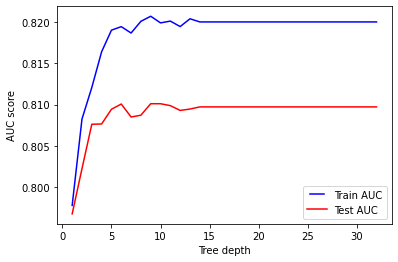

0


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f19bb2ee4c0>)])),
                ('classifier',
                 HistGradientBoostingClassifier(max_depth=9, max_leaf_nodes=20,
                                                min_samples_leaf=35,
                                                random_state=42))])

In [17]:
'''testing optimal max depth'''
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for depth in max_depths:
    model = fullmodel.set_params(classifier__max_depth = int(depth))
    model.fit(x_train, y_train)   
    train_pred = model.predict(x_train) 
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)   
    y_pred = model.predict(x_test)   
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()
depth = np.where(np.array(train_results) - np.array(test_results) == np.min(np.array(train_results) - np.array(test_results)))[0][-1]
print(depth)
fullmodel.set_params(classifier__max_depth = max_depth)

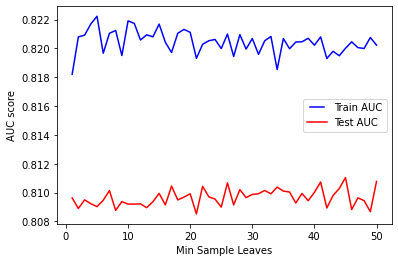

33


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f19bb2ee4c0>)])),
                ('classifier',
                 HistGradientBoostingClassifier(max_depth=9, max_leaf_nodes=20,
                                                min_samples_leaf=35,
                                                random_state=42))])

In [18]:
'''testing optimal min samples leaves'''
min_samples_leaves = np.linspace(1, 50, 50, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leaves:
    model = fullmodel.set_params(classifier__min_samples_leaf = int(min_samples_leaf))
    model.fit(x_train, y_train)   
    train_pred = model.predict(x_train) 
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)   
    y_pred = model.predict(x_test)   
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leaves, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leaves, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Min Sample Leaves')
plt.show()
leaves = np.where(np.array(train_results) - np.array(test_results) == np.min(np.array(train_results) - np.array(test_results)))[0][-1]
print(leaves)
fullmodel.set_params(classifier__min_samples_leaf = min_samples)

In [19]:
max_leaf_nodes = np.linspace(2, 50, 50, endpoint=True)
train_results = []
test_results = []
for leaf in max_leaf_nodes:
    model = fullmodel.set_params(classifier__max_leaf_nodes = int(leaf))
    model.fit(x_train, y_train)   
    train_pred = model.predict(x_train) 
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)   
    y_pred = model.predict(x_test)   
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_leaf_nodes, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_leaf_nodes, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Max Leaf Nodes')
plt.show()
max_leaves = np.where(np.array(train_results) - np.array(test_results) == np.min(np.array(train_results) - np.array(test_results)))[0][-1]
print(max_leaves)
fullmodel.set_params(classifier__max_leaf_nodes = max_leaf)

,Hours per Week,Age,Workclass,Highest Degree,Marital Status,Race,Gender,Native Country,Occupation,Income Actual,Income Adjust,Income
0,20,40,Private,Undergraduate Degree,Married,White,Female,United States,Tech Support,49100,83475.473800,1
1,40,21,Private,High School Graduate,Divorced,White,Male,United States,Craft/Repair,11500,19551.282050,0
2,10,17,Private,Less than High School,Never Married,White,Male,United States,Other Services,2600,4420.289855,0
3,50,51,Private,High School Graduate,Married,Asian/Pacific Islander,Male,Cambodia,Sales,38997,66299.247490,1
4,38,26,Private,Undergraduate Degree,Never Married,White,Male,United States,Executive/Managerial,38524,65495.094760,1
...,...,...,...,...,...,...,...,...,...,...,...,...
45844,65,35,Private,Undergraduate Degree,Married,White,Male,Yugoslavia,Farming/Fishing,85080,144645.484900,1
45845,77,37,Self Employed (Unincorporated),Undergraduate Degree,Married,Asian/Pacific Islander,Male,Vietnam,Sales,34137,58036.705690,1
45846,55,24,Private,Undergraduate Degree,Never Married,White,Male,United States,Sales,13016,22128.651060,0
45847,40,24,Private,High School Graduate,Never Married,White,Female,United States,Administrative/Clerical,15000,25501.672240,0


In [11]:
df.iloc[[0]].drop(labels = ['Ocupation'])

KeyError: "['Ocupation'] not found in axis"

In [10]:
df

,Hours per Week,Age,Workclass,Highest Degree,Marital Status,Race,Gender,Native Country,Occupation,Income
0,20,40,Private,Undergraduate Degree,Married,White,Female,United States,Tech Support,1
1,40,21,Private,High School Graduate,Divorced,White,Male,United States,Craft/Repair,0
2,10,17,Private,Less than High School,Never Married,White,Male,United States,Other Services,0
3,50,51,Private,High School Graduate,Married,Asian/Pacific Islander,Male,Cambodia,Sales,1
4,38,26,Private,Undergraduate Degree,Never Married,White,Male,United States,Executive/Managerial,1
...,...,...,...,...,...,...,...,...,...,...
45844,65,35,Private,Undergraduate Degree,Married,White,Male,Yugoslavia,Farming/Fishing,1
45845,77,37,Self Employed (Unincorporated),Undergraduate Degree,Married,Asian/Pacific Islander,Male,Vietnam,Sales,1
45846,55,24,Private,Undergraduate Degree,Never Married,White,Male,United States,Sales,0
45847,40,24,Private,High School Graduate,Never Married,White,Female,United States,Administrative/Clerical,0
